## Leonard Molano  |  Group 6  |   October 17, 2020
### Credit Card Customer Segmentation

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.
Attributes of the data:
- Customer key - Identifier for the customer
- Average Credit Limit - Average credit limit across all the credit cards
- Total credit cards - Total number of credit cards
- Total visits bank - Total number of bank visits
- Total visits online - total number of online visits
- Total calls made - Total number of calls made by the customer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
cc_data = pd.read_excel('Credit Card Customer Data.xlsx')

In [4]:
cc_data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
# Removing unnecessary fields
cc_data = cc_data.drop('Customer Key', axis=1)
cc_data = cc_data.drop('Sl_No', axis=1)

In [6]:
cc_data.shape

cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [7]:
cc_data.skew()

Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

In [8]:
cc_data.dtypes

Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [9]:
cc_data.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

`They are no null values in the dataset!`

In [10]:
cc_data.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [11]:
cc_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


`The data looks pretty standard for the most part. The only observation I could make is that Avg_Credit_Limit seem rather high on the mean`

## Univarate Analysis

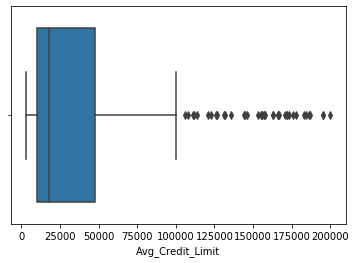

In [12]:
sns.boxplot(cc_data['Avg_Credit_Limit'])

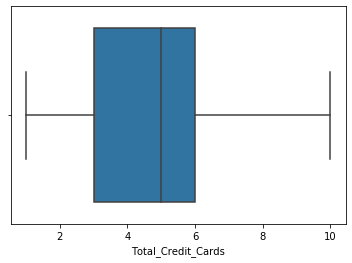

In [13]:
sns.boxplot(cc_data['Total_Credit_Cards'])

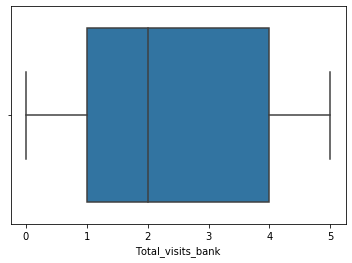

In [14]:
sns.boxplot(cc_data['Total_visits_bank'])

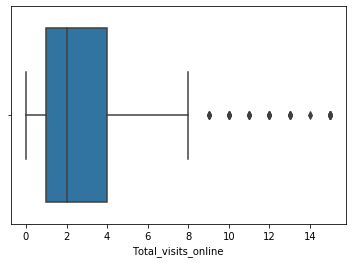

In [15]:
sns.boxplot(cc_data['Total_visits_online'])

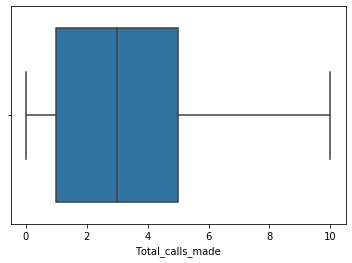

In [16]:
sns.boxplot(cc_data['Total_calls_made'])

`The data fields with most outliers are: Avg_Credit_Limit and Total_visits_online. Most fields are slighly skewed to the right, but nothing concerning for our analysis. The data will be normalized regardless to take care of the outliers.`

## Bi-Variate Analysis

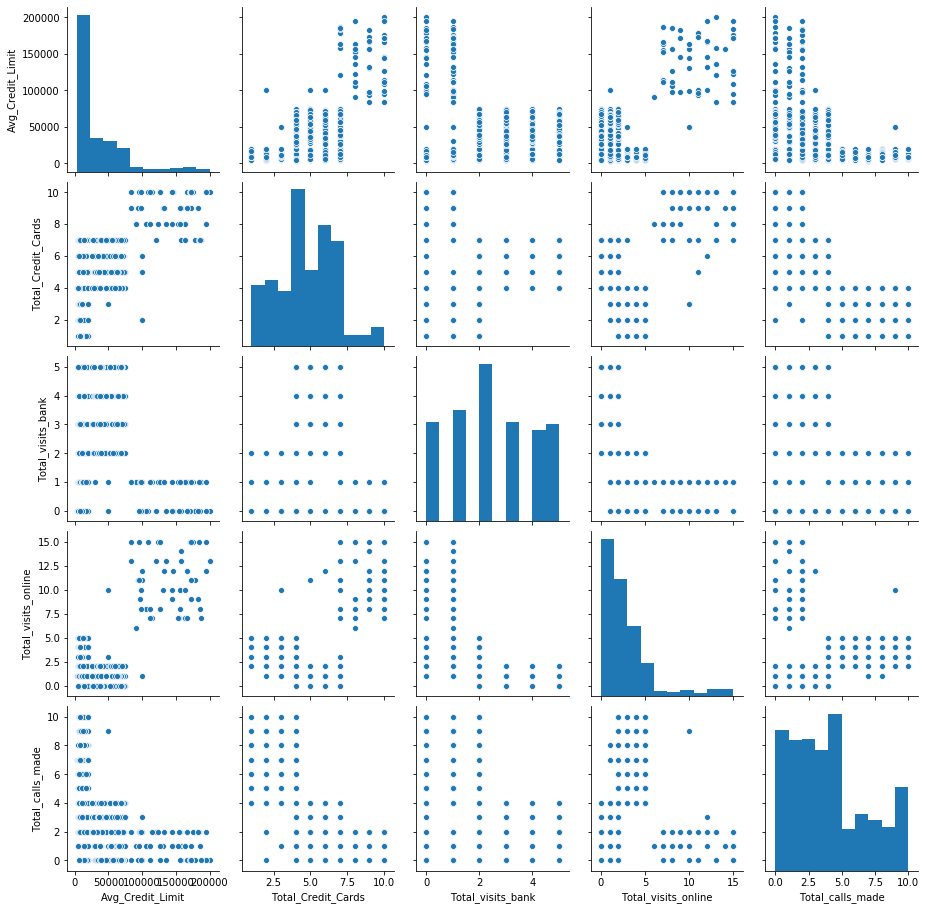

In [17]:
sns.pairplot(cc_data)

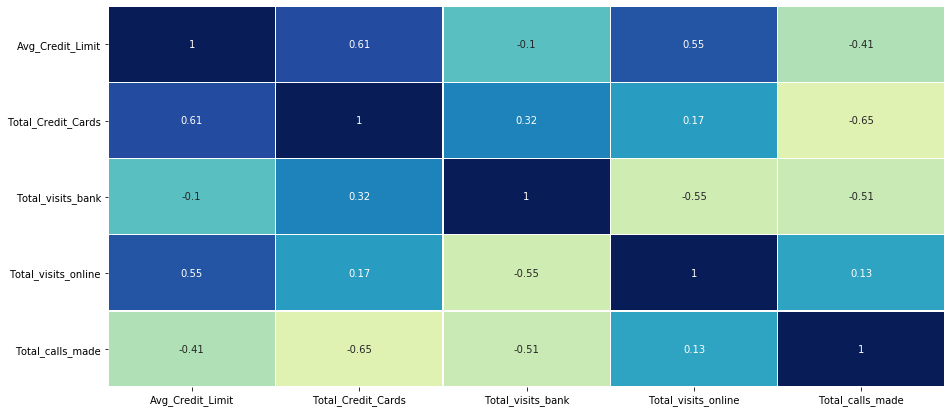

In [18]:
plt.figure(figsize=(15,7))
sns.heatmap(cc_data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

`Based on the Bi-Variate Analysis, there is a good ammount of correlation between most of the variables.`

## Feature Engineering

In [19]:
cc_tmp = cc_data.copy()

In [20]:
# Scale the data using Z-Scores
cc = cc_tmp.apply(zscore)

In [21]:
# Remove extreme outliers
for i in cc.columns :
    median = cc[i].median()
    q1 = np.quantile(cc[i], 0.25)
    q3 = np.quantile(cc[i], 0.75)
    iqr = q3 - q1
    lw = q1 - (1.5 * iqr) 
    uw = q3 + (1.5 * iqr) 
    cc[i] = np.where((cc[i] < lw) | (cc[i] > uw) , median, cc[i])

In [22]:
cc.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.54749,-1.251537
1,0.410293,-0.787585,-1.473731,-0.20660,1.891859
2,0.410293,1.058973,-0.860451,0.13429,0.145528
3,-0.121665,0.135694,-0.860451,-0.54749,0.145528
4,1.740187,0.597334,-1.473731,-0.20660,-0.203739


## Elbow Plot

In [23]:
cck = cc.copy()

In [24]:
distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(cck)
    prediction = k_means.predict(cck)
    distortions.append(sum(np.min(cdist(cck, k_means.cluster_centers_, 'euclidean'), axis=1)) / cck.shape[0])

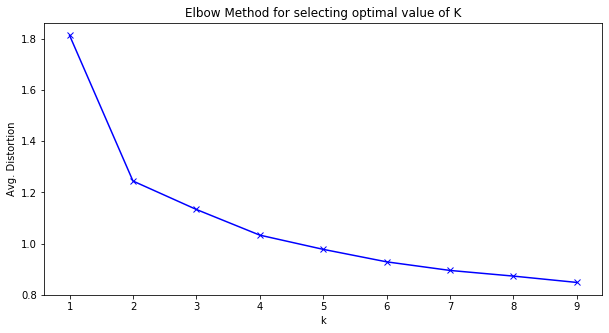

In [25]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Avg. Distortion')
plt.title('Elbow Method for selecting optimal value of K')
plt.show()

`Based on the elbow plots the best K's is 2`

## K_Means Clustering (2 Clusters)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2ba1d0d0>,
      dtype=object)

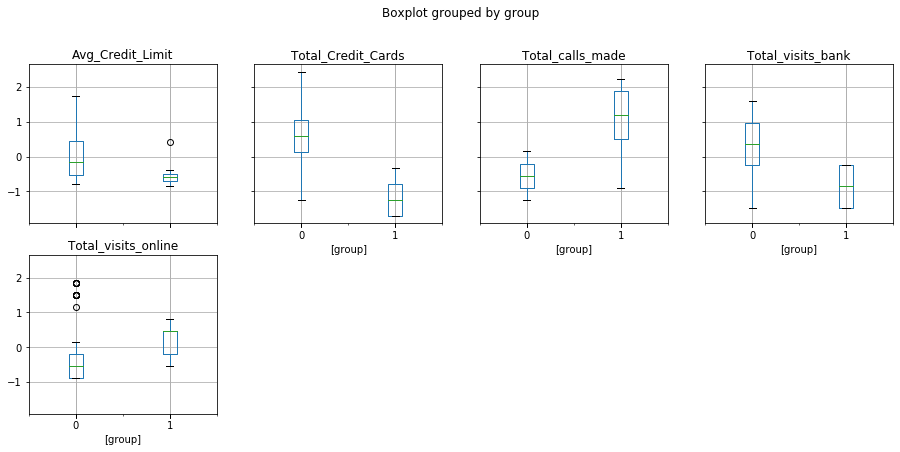

In [26]:
# Create K-Means model with k=2
kmeanModel = KMeans(n_clusters=2)
kclusters = kmeanModel.fit_predict(cck)

# Add cluster labels to our dataframe
cck['group'] = kclusters
cck['group'] = cck['group'].astype('category')
cck.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

Group 0 is characterized by individuals with low avg credit limit, low amount of credit cards, a high amount of calls made, low bank visits and a moderate amount of online visits. 

Group 1 for the most part is the opposite of Group 0, except they tend to physically go to the bank instead of resolving issues online or by phone.

In [27]:
# Silhouette Score
kss = ['K-Means (2)', silhouette_score(cck, kclusters)]
print(kss)

['K-Means (2)', 0.4919242640802323]


## Hierarchial Clustering (Ward Linkage) 

In [28]:
wa_cc = cc.copy()

In [29]:
Z = linkage(wa_cc, 'ward', metric='euclidean')

In [30]:
coph_dists = cophenet(Z, pdist(wa_cc))
coph_dists

(0.7716562663655376,
 array([49.76286249,  6.28967355,  6.87258246, ...,  3.41840883,
         3.41840883,  1.83261079]))

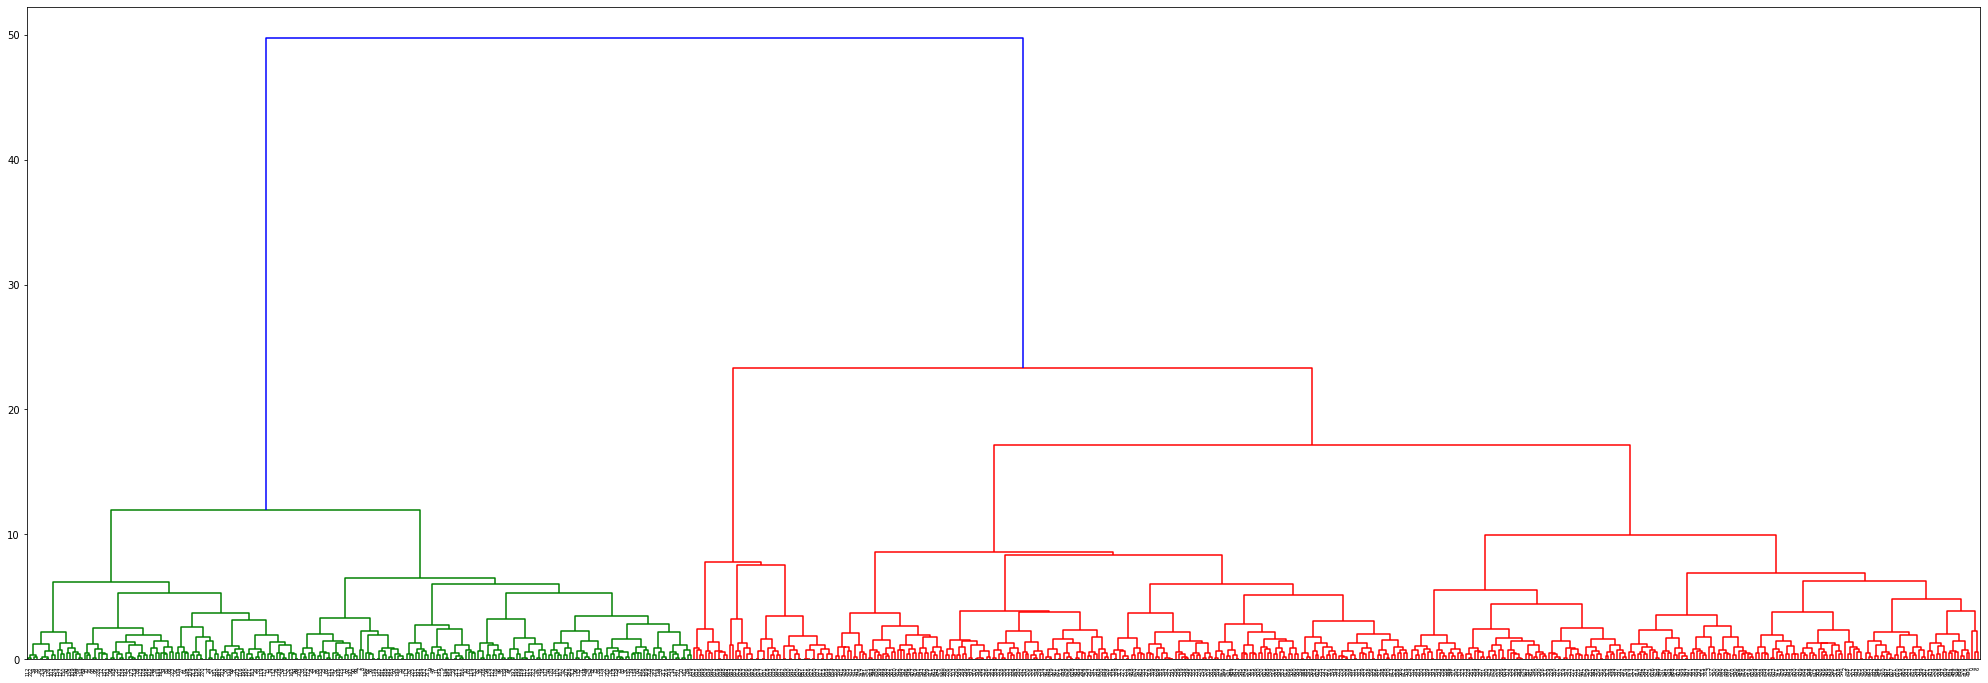

In [31]:
plt.figure(figsize=(35, 12))
dendrogram(Z)
plt.show()

`Based on the dendogram, we will use k=2 for creating our model`

In [32]:
WardAggloClustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
WardClusters = WardAggloClustering.fit_predict(wa_cc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2dc86f10>,
      dtype=object)

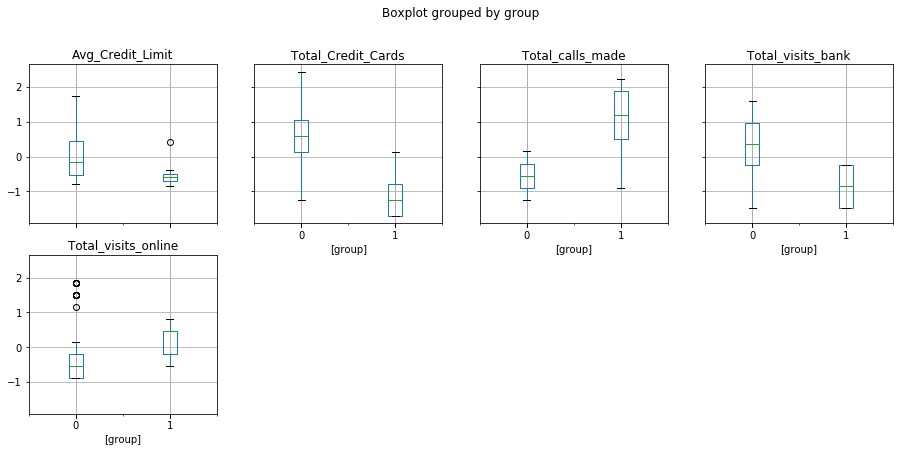

In [33]:
wa_cc['group'] = WardClusters
wa_cc['group'] = wa_cc['group'].astype('category')
wa_cc.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

Most groups seem fairly balanced. The only thing we would need to be careful of is analysing total online visits.

In [34]:
wss = ['Ward Linkage', silhouette_score(wa_cc, WardClusters)]
print(wss)

['Ward Linkage', 0.4910486321835456]


## Hierarchial Clustering (Complete Linkage)

In [35]:
co_cc = cc.copy()

In [36]:
Z = linkage(co_cc, 'complete', metric='euclidean')

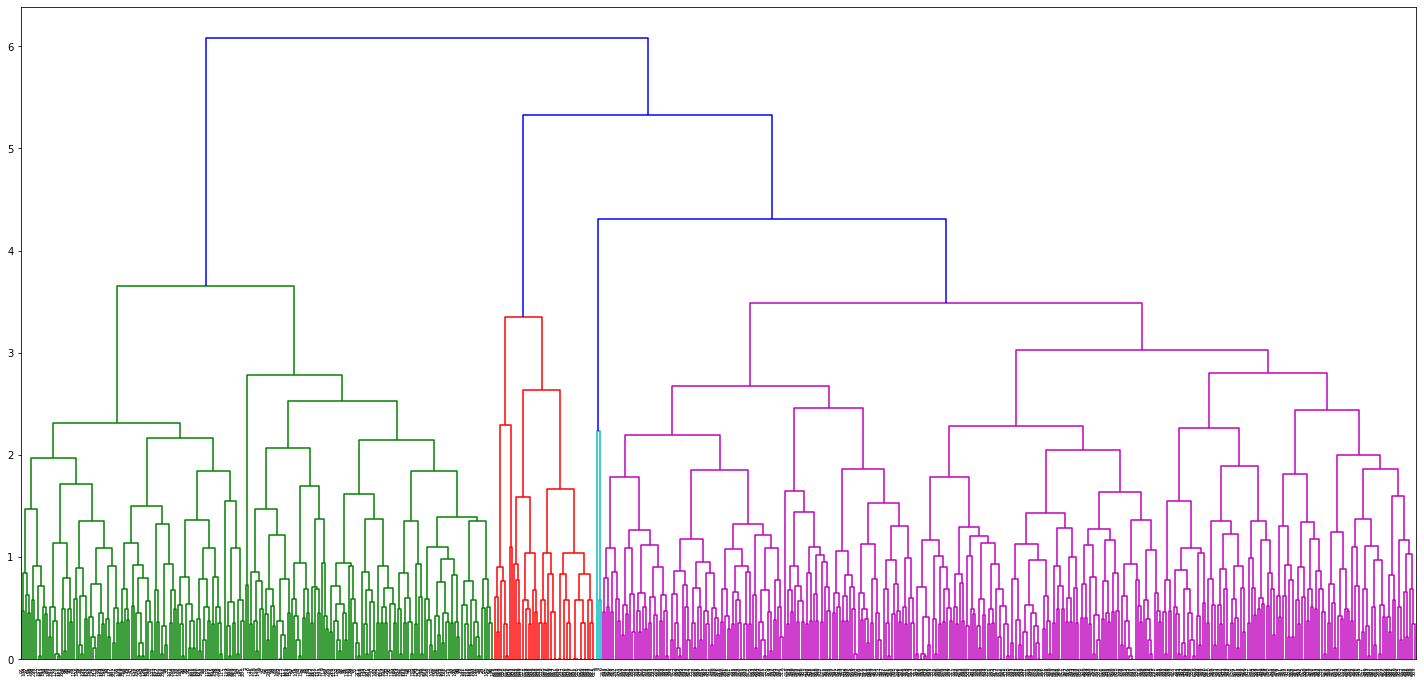

In [37]:
plt.figure(figsize=(25, 12))
dendrogram(Z)
plt.show()

`Based on the dendogram, we will use k=4 for creating our model`

In [38]:
CompAggloClustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
CompleteClusters = CompAggloClustering.fit_predict(co_cc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2c9f3b90>,
      dtype=object)

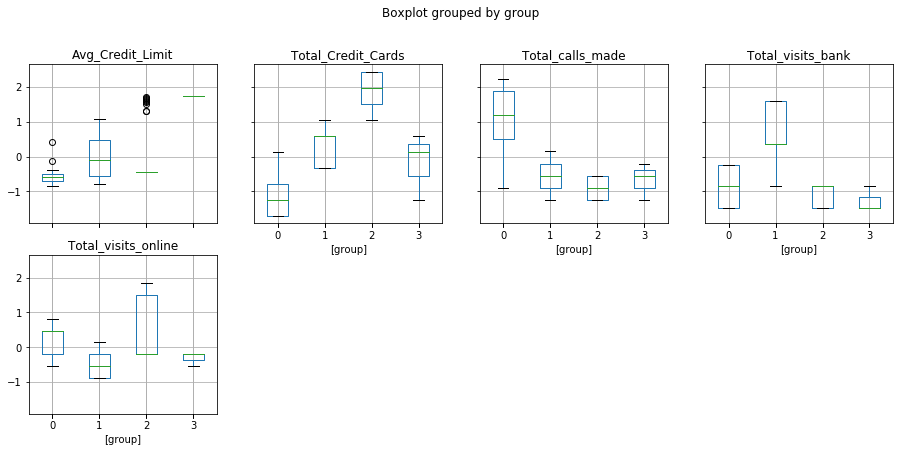

In [39]:
co_cc['group'] = CompleteClusters
co_cc['group'] = co_cc['group'].astype('category')
co_cc.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

Avg Credit Limit contain a high amount of outliers which we need to be careful of. The rest of the groups seem balanced.

In [40]:
css = ['Complete Linkage', silhouette_score(co_cc, CompleteClusters)]
print(css)

['Complete Linkage', 0.4918762940938699]


## Hierarchial Clustering (Average Linkage)

In [41]:
av_cc = cc.copy()

In [42]:
Z = linkage(av_cc, 'average', metric='euclidean')

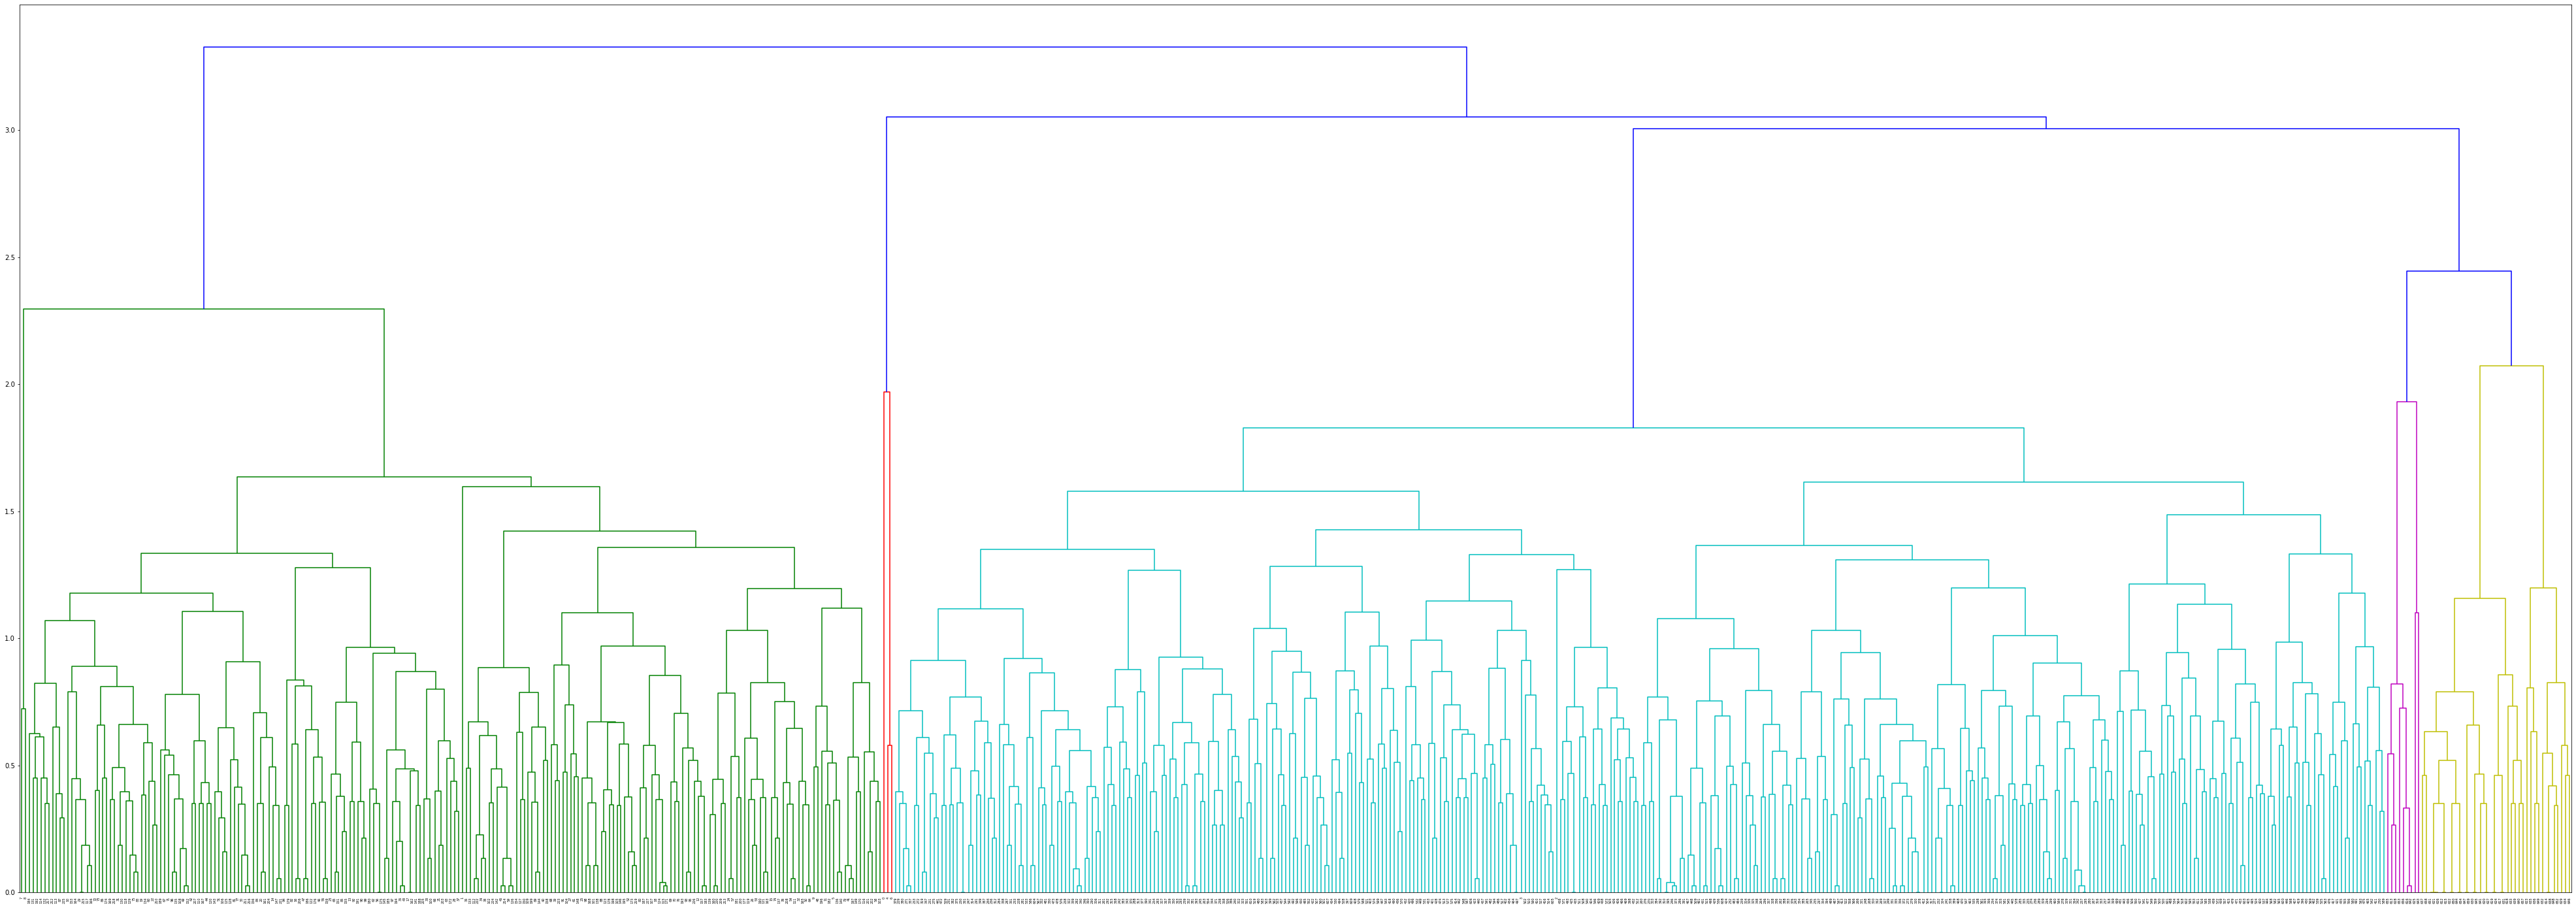

In [43]:
plt.figure(figsize=(70, 25))
dendrogram(Z)
plt.show()

`Based on the dendogram, we will use k=5 for creating our model`

In [44]:
AvgAggloClustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
AvgClusters = AvgAggloClustering.fit_predict(av_cc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d5f4510>,
      dtype=object)

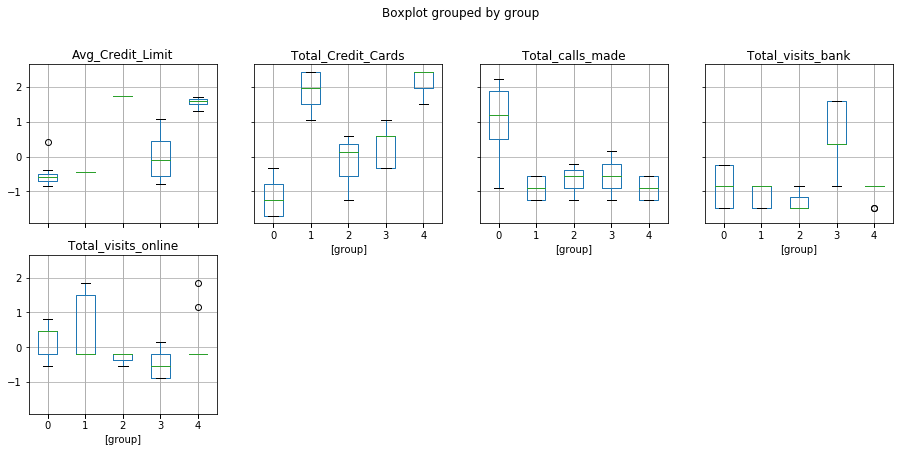

In [45]:
av_cc['group'] = AvgClusters
av_cc['group'] = av_cc['group'].astype('category')
av_cc.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

Most created groups seemed to be balanced, with Avg Credit Limit being very precise in their observations. The Total Online Visits have some extreme outliers that we need to be careful of. Overall this seems like a good model to use for our use case.

In [46]:
ass = ['Average Linkage', silhouette_score(av_cc, AvgClusters)]
print(css)

['Complete Linkage', 0.4918762940938699]


## Model Comparisons

In [47]:
results = pd.DataFrame(columns=['Model', 'Silhouette Score'])
results.loc[0] = kss
results.loc[1] = wss
results.loc[2] = css
results.loc[3] = ass

In [48]:
results

,Model,Silhouette Score
0,K-Means (2),0.491924
1,Ward Linkage,0.491049
2,Complete Linkage,0.491876
3,Average Linkage,0.527161


Most models are pretty close to each other, with Average Linkage being the model with the best Silhouette Score. In addition, the boxplot analysis did not present any big discrepency with how it grouped the clusters (with the exception of a couple of outliers). 